In [10]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [11]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Descărcăm datele necesare

In [12]:
train_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

Pregătim datele pentru rețeaua neuronală

In [13]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Vizualizăm datele

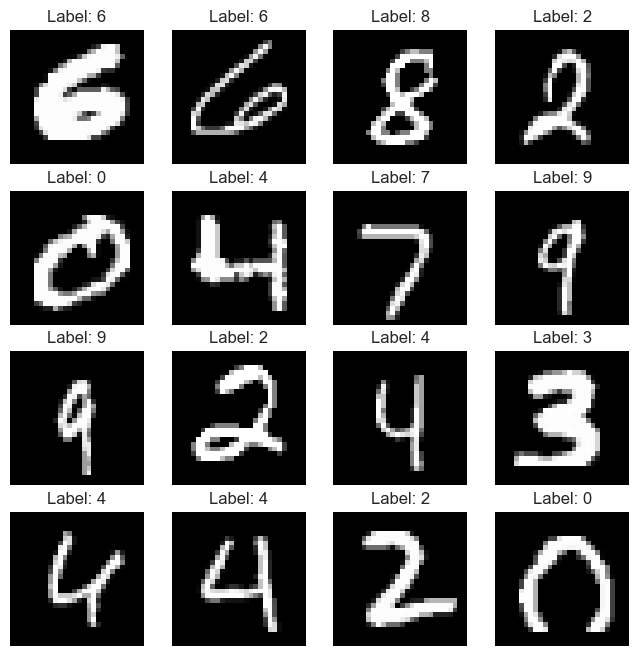

In [14]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Definim rețeaua neuronală

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),  # Input layer
            nn.ReLU(),  # Non-linearity
            nn.Linear(512, 512),  # Hidden layer
            nn.ReLU(),
            nn.Linear(512, 10)  # Output layer (10 digits)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Inițializăm modelul

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Definim modul de antrenare și de testare a modelului

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    accuracy = correct / size
    return train_loss, accuracy


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, accuracy

Antrenăm modelul

In [18]:
epochs = 10
history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_loss, tr_acc = train_loop(train_loader, model, loss_fn, optimizer)
    te_loss, te_acc = test_loop(test_loader, model, loss_fn)

    history['train_loss'].append(tr_loss)
    history['test_loss'].append(te_loss)
    history['train_acc'].append(tr_acc)
    history['test_acc'].append(te_acc)

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 51.9%, Avg loss: 2.192944 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 68.6%, Avg loss: 1.891529 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 75.8%, Avg loss: 1.267702 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.833752 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.638273 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.536774 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.475699 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 88.3%, Avg loss: 0.435048 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.406167 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.384644 

Done!


Afișăm graficele metriciilor modelului

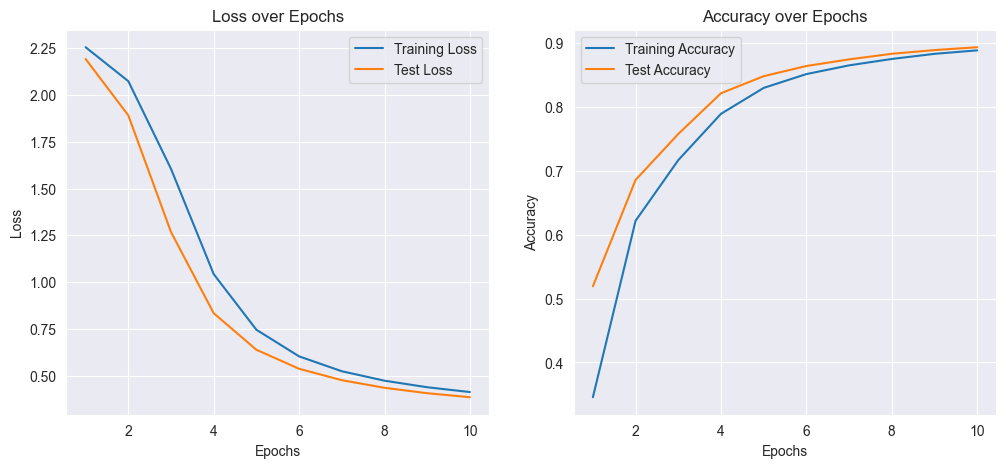

In [19]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['test_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['test_acc'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()